## Including Headers

In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
import sklearn
import random
import time

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from matplotlib import pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
random.seed(42)



###  First Attempt: Classification with all nodes and using undirected network

In [2]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    '''
        This method in based on:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    '''
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
    
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

#### Defining all classifiers and parameters

In [3]:

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(kernel="sigmoid", C=0.025, probability=True),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]
cls = ['KNN',
      "SVM linear",
       "SVM sigmoid",
      "SVM RBF",
      "SVM gamma",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"
      ]

#### Reading data

In [4]:
sce = pd.read_csv("data/scerevisiae_all.csv")
ecoli = pd.read_csv("data/ecoli_all.csv")
pae = pd.read_csv("data/paeruginosa_all.csv")
mge = pd.read_csv("data/mgenitalium_all.csv")

#### Splitting train and test datasets

In [5]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = ecoli.iloc[:,2:-1],ecoli['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Machine Learning one vs one

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



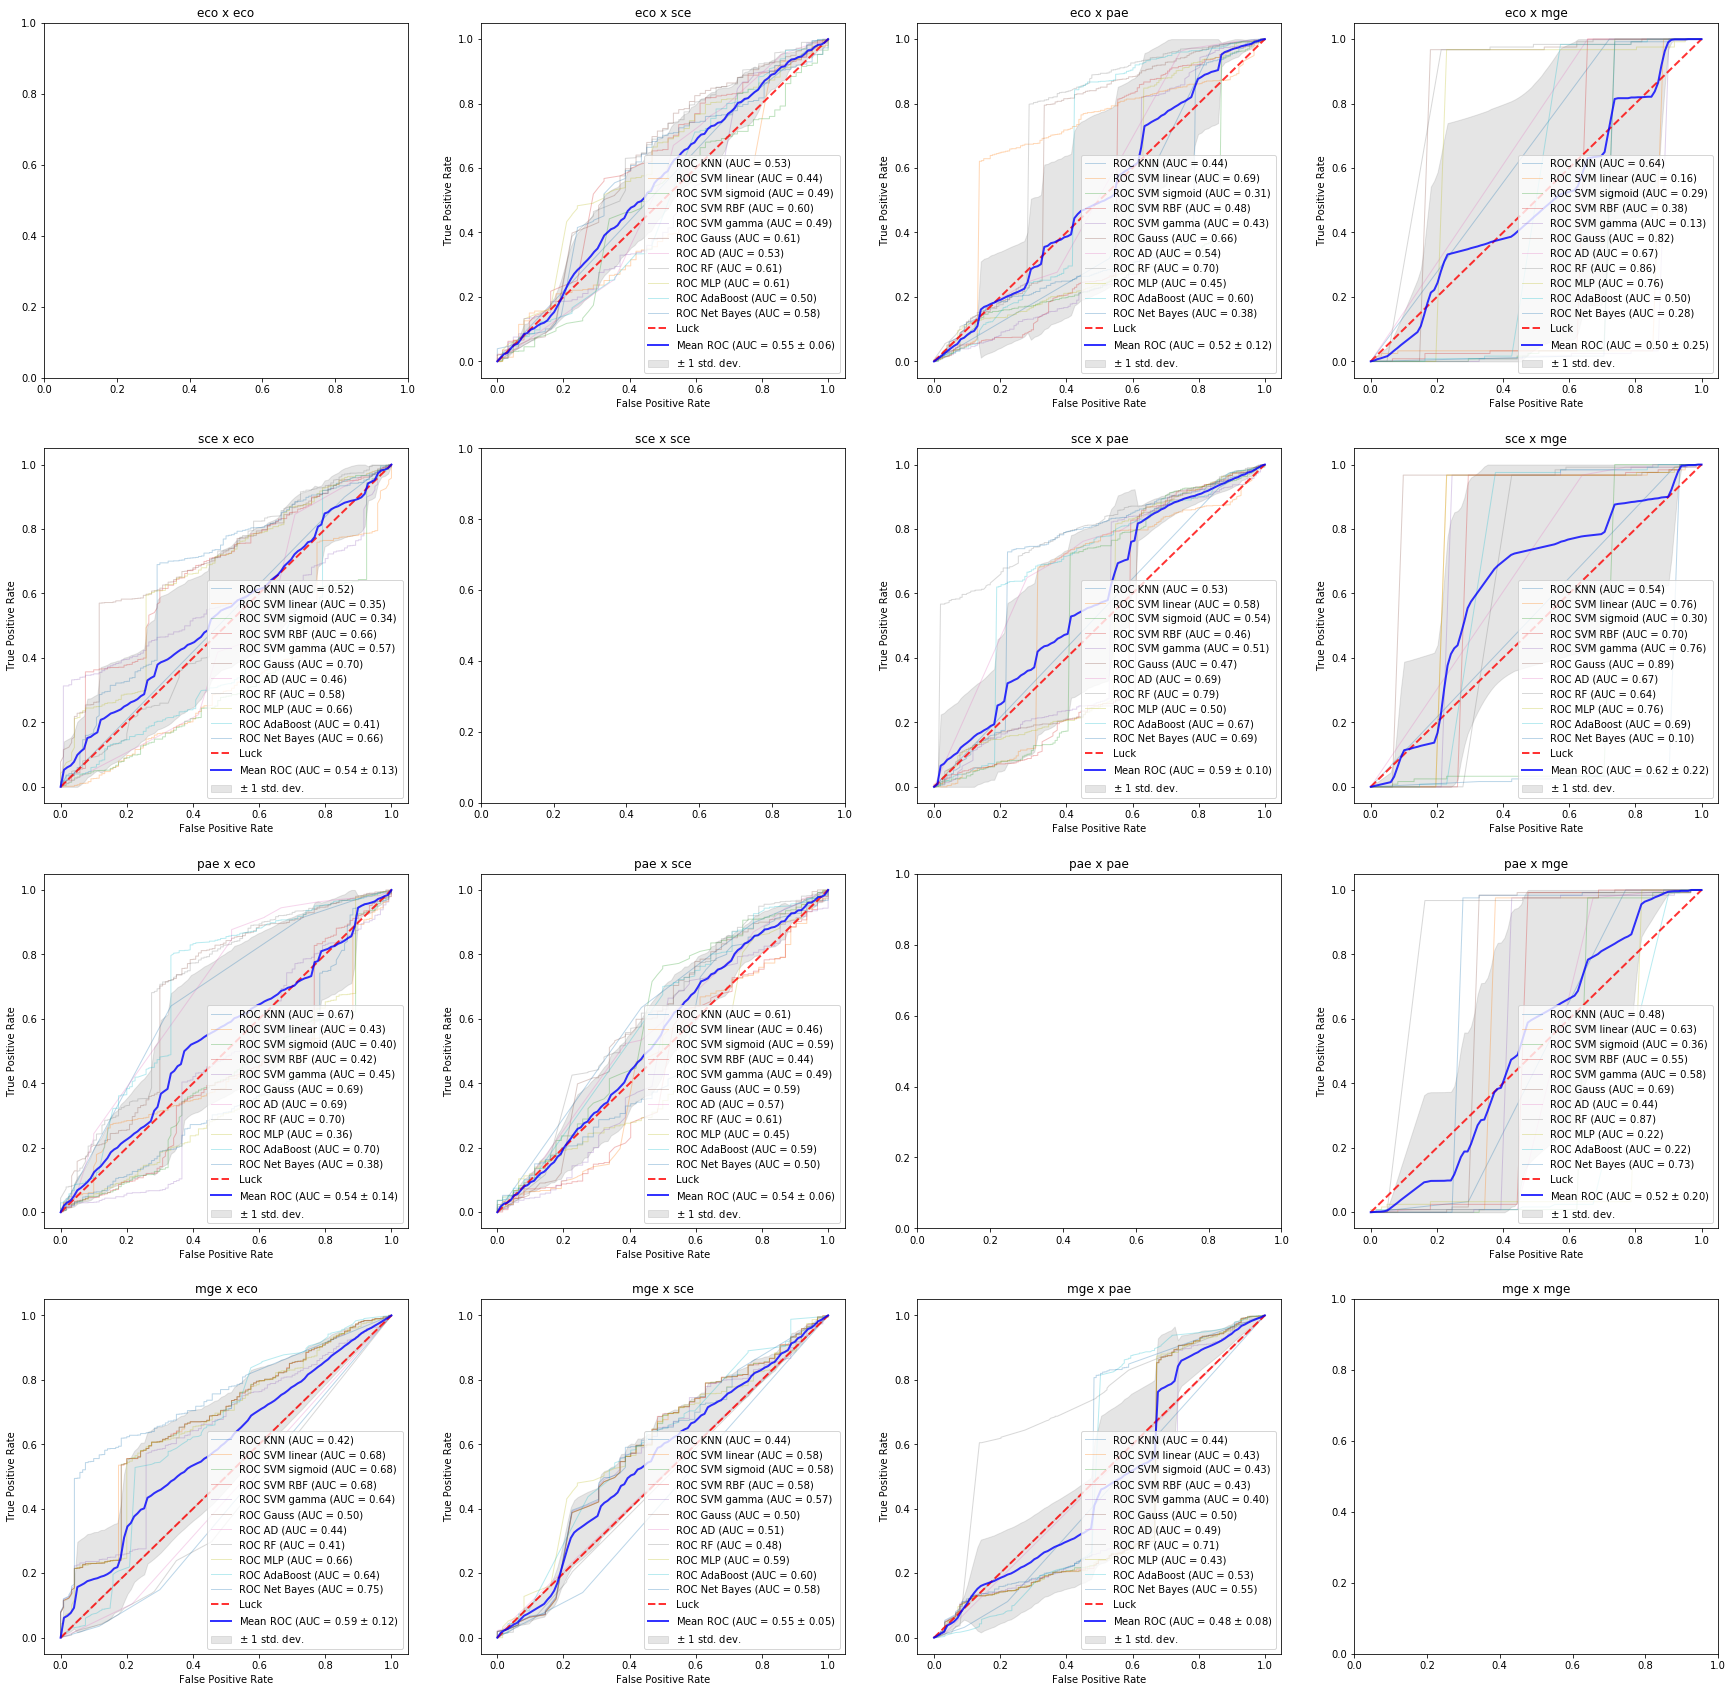

In [6]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 4
col = 4
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2]!= j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
        else:
            a = fig.add_subplot(row, col, pcount)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
fig.savefig("all_classifiers.png")

#### Attempt to improve SVM acc


In [7]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
svc = svm.SVC(probability=True)
grid = GridSearchCV(svc, parameters)
rand = RandomizedSearchCV(svc, parameters)

classifiers = [grid, rand]
cls = ['GridSearchCV', 'RandomizedSearchCV']

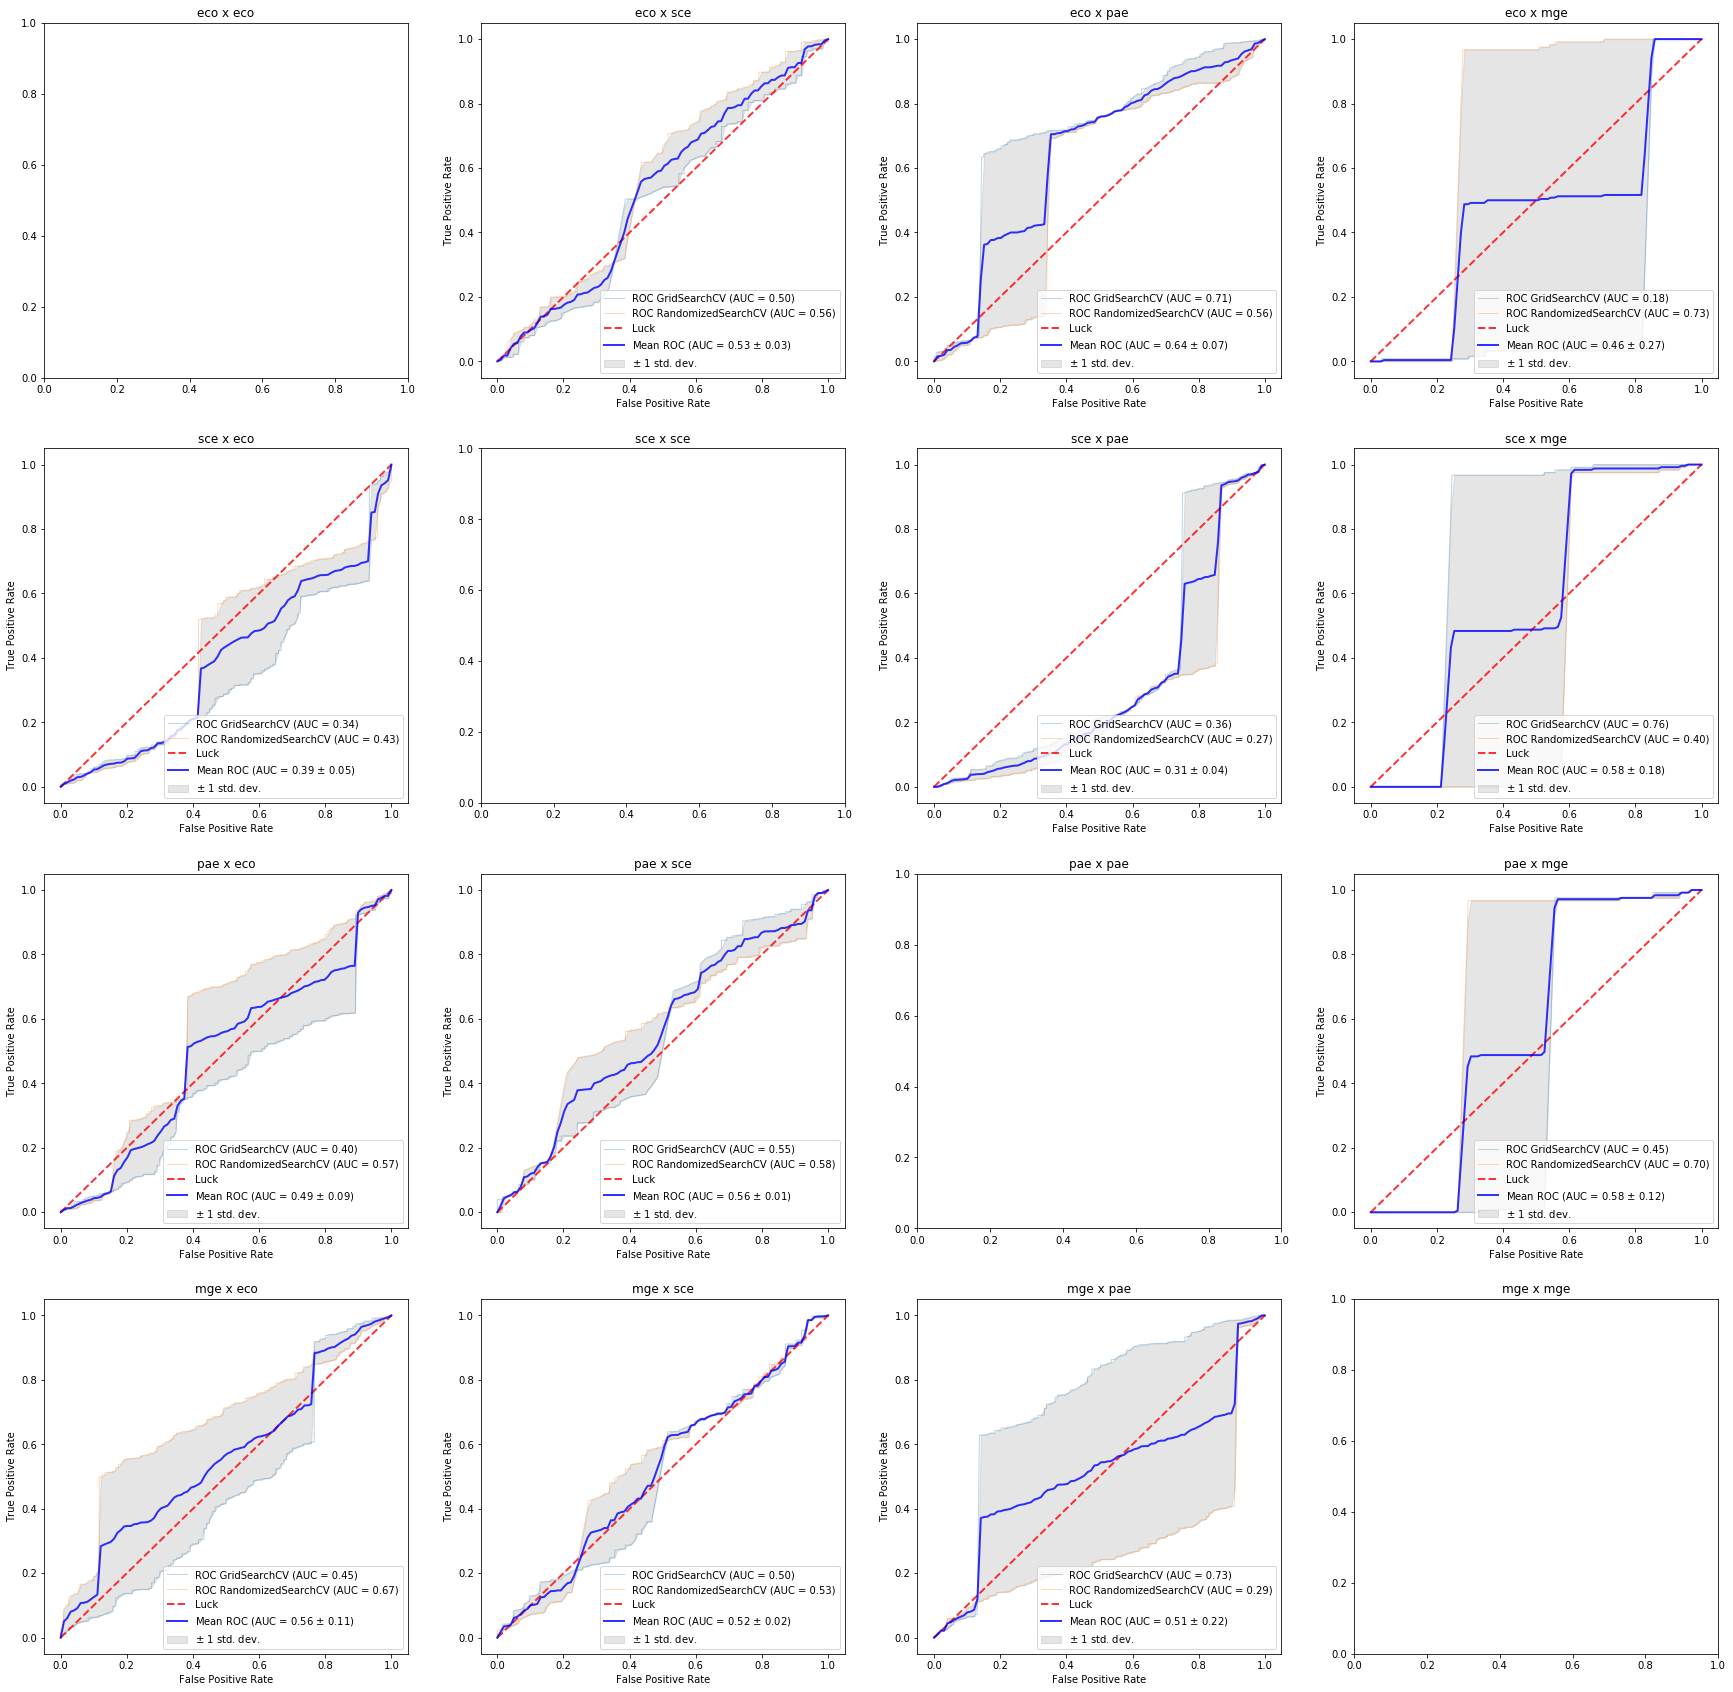

In [8]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 4
col = 4
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2] != j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
        else: 
            a = fig.add_subplot(row, col, pcount)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
plt.show()

#### Building dataset: Leave one out strategy

In [9]:

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(kernel="sigmoid", C=0.025, probability=True),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]
cls = ['KNN',
      "SVM linear",
       "SVM sigmoid",
      "SVM RBF",
      "SVM gamma",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"
      ]

In [10]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

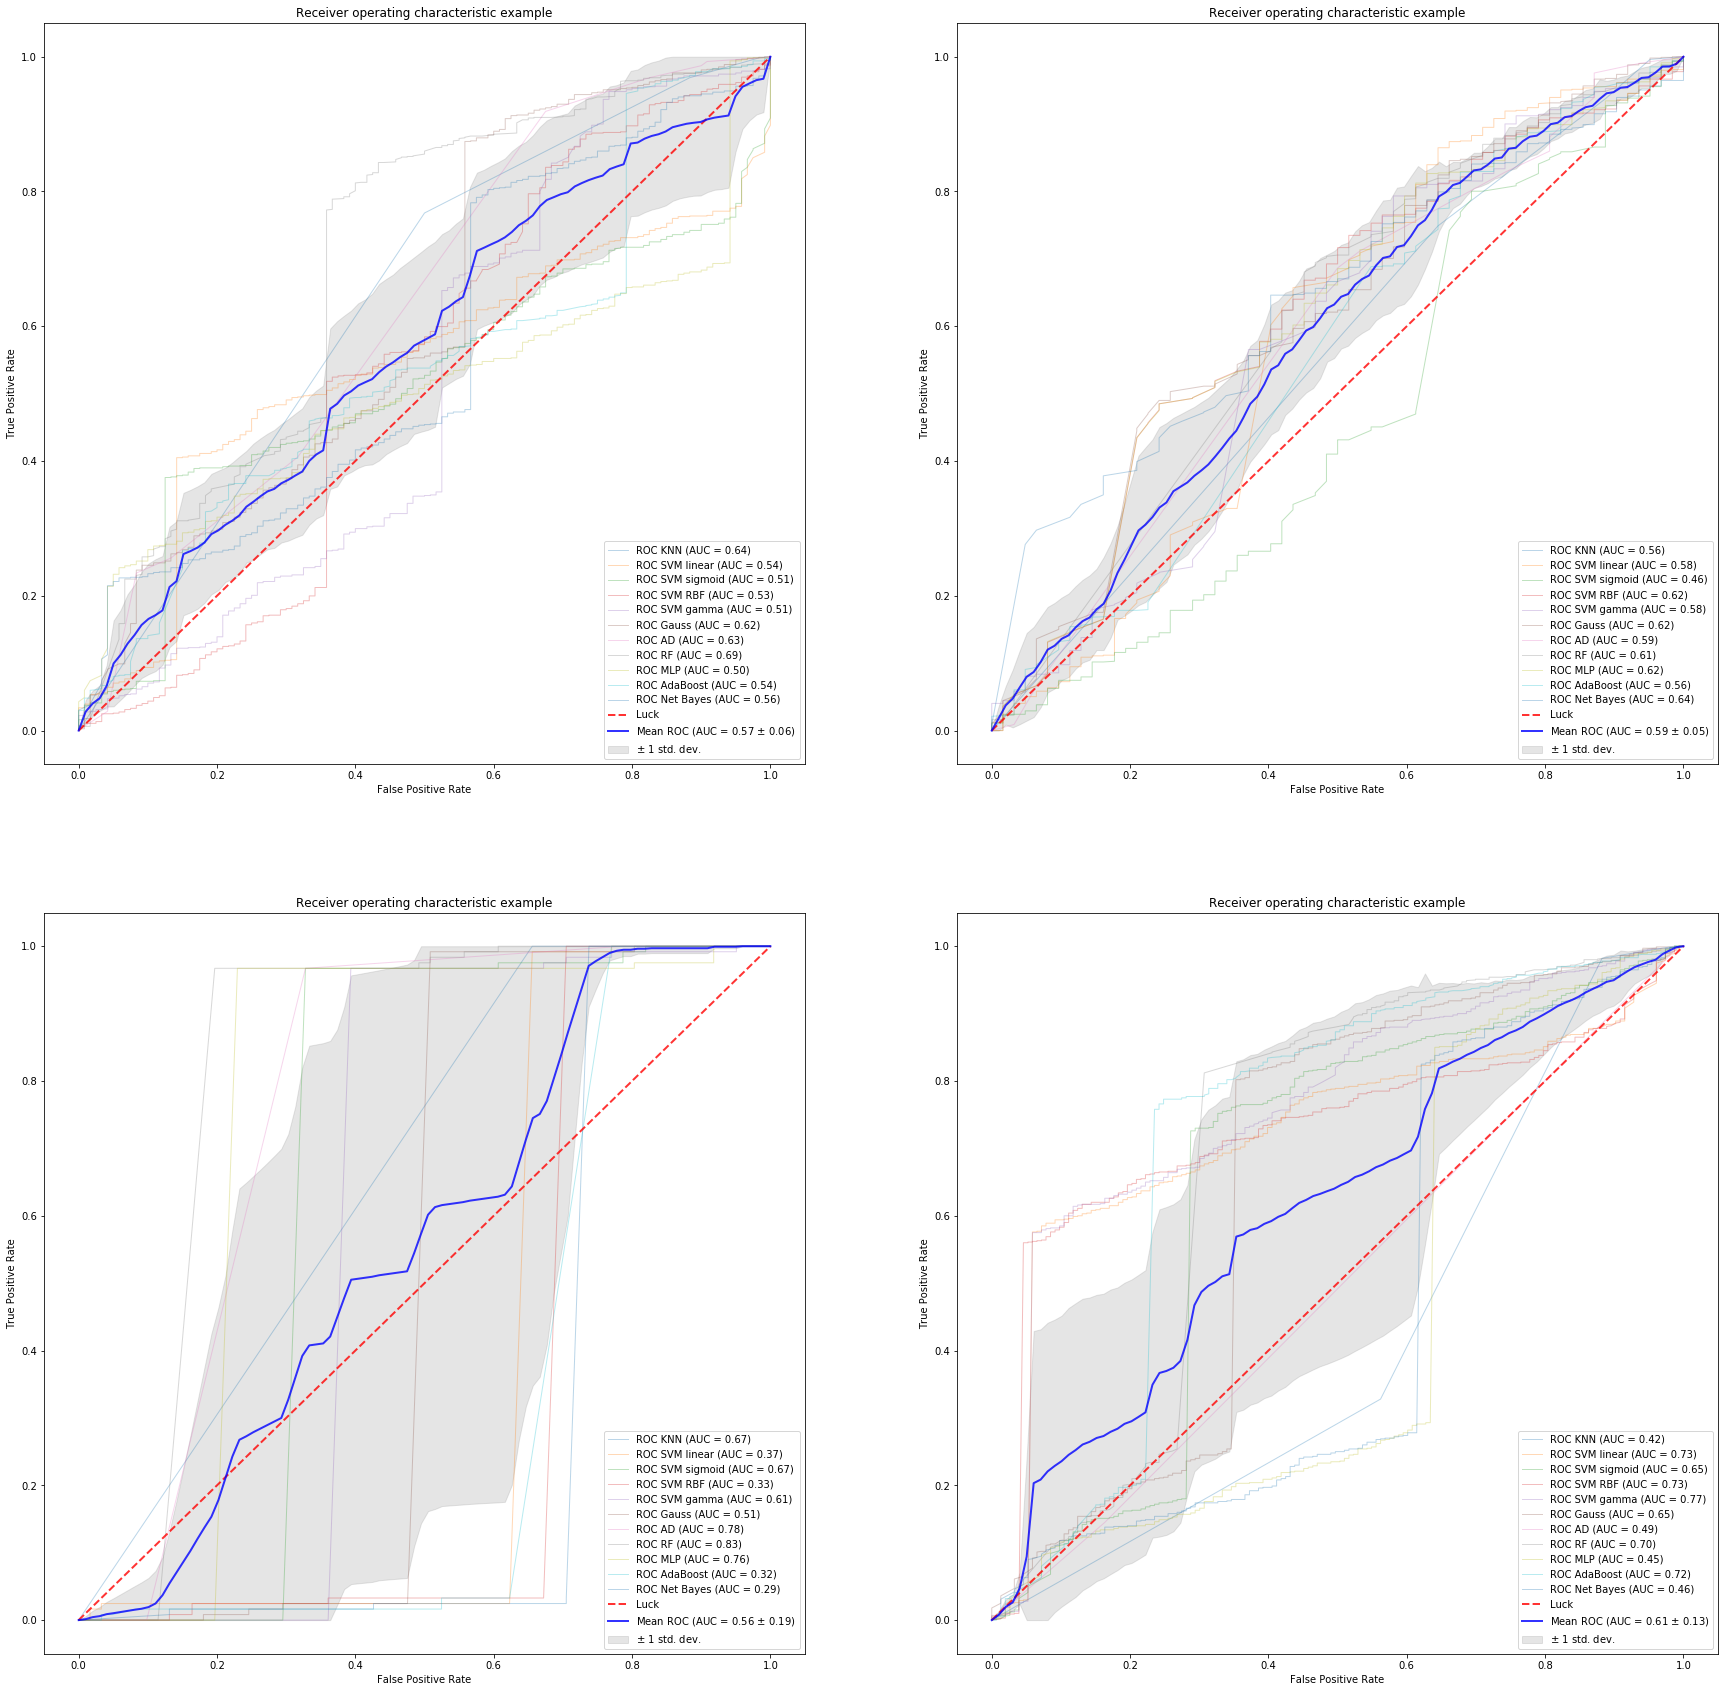

In [11]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 =  time.time() -s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 =  time.time() -s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 =  time.time() -s4
fig.savefig("all_nfs.png")


In [12]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 202.09756588935852 seconds ---
Dataset2: --- 240.9679458141327 seconds ---
Dataset3: --- 502.3716902732849 seconds ---
Dataset4: --- 129.39330649375916 seconds ---


#### Testing Machine Learning Classifiers with Feature Selection

In [13]:
X_new1 = SelectKBest(chi2, k=7).fit(train1_x,train1_y)
ntrain1_x = train1_x.iloc[:,X_new1.get_support()]
ntest1_x = test1_x.iloc[:,X_new1.get_support()]
#------------------------------------------------------------------------------------
X_new2 = SelectKBest(chi2, k=7).fit(train2_x,train2_y)
ntrain2_x = train2_x.iloc[:,X_new2.get_support()]
ntest2_x = test2_x.iloc[:,X_new2.get_support()]
#------------------------------------------------------------------------------------
X_new3 = SelectKBest(chi2, k=7).fit(train3_x,train3_y)
ntrain3_x = train3_x.iloc[:,X_new3.get_support()]
ntest3_x = test3_x.iloc[:,X_new3.get_support()]
#------------------------------------------------------------------------------------
X_new4 = SelectKBest(chi2, k=7).fit(train4_x,train4_y)
ntrain4_x = train4_x.iloc[:,X_new4.get_support()]
ntest4_x = test4_x.iloc[:,X_new4.get_support()]


In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(ntrain1_x,train1_y,ntest1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(ntrain2_x,train2_y,ntest2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 = time.time() - s2
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(ntrain3_x,train3_y,ntest3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(ntrain4_x,train4_y,ntest4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4
fig.savefig("all_fs.png")


In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

###  Second Attempt: Classification without isolate nodes and using undirected network

#### Reading data

In [ ]:
sce = pd.read_csv("data/scerevisiae.csv")
ecoli = pd.read_csv("data/ecoli.csv")
pae = pd.read_csv("data/paeruginosa.csv")
mge = pd.read_csv("data/mgenitalium.csv")

#### Splitting train and test datasets

In [ ]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = ecoli.iloc[:,2:-1],ecoli['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Machine Learning one vs one

In [ ]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 4
col = 4
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2] != j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
        else:
            a = fig.add_subplot(row, col, pcount)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
fig.savefig("all_classifiers.png")

#### Building dataset: Leave one out strategy

In [ ]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 =  time.time() -s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 =  time.time() -s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 =  time.time() -s4
fig.savefig("wi_nfs.png")

In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

#### Testing Machine Learning Classifiers with Feature Selection

In [ ]:
X_new1 = SelectKBest(chi2, k=7).fit(train1_x,train1_y)
ntrain1_x = train1_x.iloc[:,X_new1.get_support()]
ntest1_x = test1_x.iloc[:,X_new1.get_support()]
#------------------------------------------------------------------------------------
X_new2 = SelectKBest(chi2, k=7).fit(train2_x,train2_y)
ntrain2_x = train2_x.iloc[:,X_new2.get_support()]
ntest2_x = test2_x.iloc[:,X_new2.get_support()]
#------------------------------------------------------------------------------------
X_new3 = SelectKBest(chi2, k=7).fit(train3_x,train3_y)
ntrain3_x = train3_x.iloc[:,X_new3.get_support()]
ntest3_x = test3_x.iloc[:,X_new3.get_support()]
#------------------------------------------------------------------------------------
X_new4 = SelectKBest(chi2, k=7).fit(train4_x,train4_y)
ntrain4_x = train4_x.iloc[:,X_new4.get_support()]
ntest4_x = test4_x.iloc[:,X_new4.get_support()]


In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(ntrain1_x,train1_y,ntest1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(ntrain2_x,train2_y,ntest2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 = time.time() - s2
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(ntrain3_x,train3_y,ntest3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(ntrain4_x,train4_y,ntest4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4
fig.savefig("wi_fs.png")



In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

#### Attempt to improve SVC acc

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}
svc = svm.SVC(probability=True)
grid = GridSearchCV(svc, parameters)
rand = RandomizedSearchCV(svc, parameters)

classifiers = [grid, rand]
cls = ['GridSearchCV', 'RandomizedSearchCV']

In [ ]:
fig = plt.figure(figsize=(30,30))
pcount = 1
row = 4
col = 4
for i in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
    for j in [(eco_x,eco_y,'eco'),(sce_x,sce_y,'sce'),(pae_x,pae_y,'pae'),(mge_x,mge_y,'mge')]:
        if i[2] != j[2]:
            tprs_dall = []
            aucs_dall = []
            mean_fpr_dall = np.linspace(0, 1, 100)
            a = fig.add_subplot(row, col, pcount)
            imgshow = roc(i[0],i[1],j[0],j[1], mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
        else: 
            a = fig.add_subplot(row, col, pcount)
            a.set_title(i[2]+" x "+j[2])
            pcount+=1
plt.show()